In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from numpy.random import randint
print("Imports Successful")

Imports Successful


In [2]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    # making sure that we choose a non-trivial value for a
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    # we need at least 4 qubits to define values up to 14
    U = QuantumCircuit(4)        
    # apply binary transformations to implement modular multiplication
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [3]:
def qft_dagger(n):
    """n-qubit QFTdagger (QFT inverse) the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [4]:
# Specify variables
n_count = 3 # number of counting qubits
a = 7

# Create QuantumCircuit
# first register has 3 qubits, second register has 4 qubits
qc = QuantumCircuit(4+n_count, n_count)

# Initialise counting qubits
# in state |+> (uniform superposition)
for q in range(n_count):
    qc.h(q)
    
# And ancilla register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw('text')

┌───┐                                             ┌───────┐┌─┐      
q_0: ┤ H ├───────■─────────────────────────────────────┤0      ├┤M├──────
     ├───┤       │                                     │       │└╥┘┌─┐   
q_1: ┤ H ├───────┼──────────────■──────────────────────┤1 QFT† ├─╫─┤M├───
     ├───┤       │              │                      │       │ ║ └╥┘┌─┐
q_2: ┤ H ├───────┼──────────────┼──────────────■───────┤2      ├─╫──╫─┤M├
     └───┘┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐└───────┘ ║  ║ └╥┘
q_3: ─────┤0     │      ├┤0     │      ├┤0     │      ├──────────╫──╫──╫─
          │             ││             ││             │          ║  ║  ║ 
q_4: ─────┤1            ├┤1            ├┤1            ├──────────╫──╫──╫─
          │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 │          ║  ║  ║ 
q_5: ─────┤2            ├┤2            ├┤2            ├──────────╫──╫──╫─
     ┌───┐│             ││             ││             │          ║  ║  ║ 
q_6: ┤ X ├┤3            ├┤3            ├┤3            ├──────────╫──╫──╫─
     └───┘└─────────────┘└─────────────┘└─────────────┘          ║  ║  ║ 
c_0: ════════════════════════════════════════════════════════════╩══╬══╬═
                                                                    ║  ║ 
c_1: ═══════════════════════════════════════════════════════════════╩══╬═
                                                                       ║ 
c_2: ══════════════════════════════════════════════════════════════════╩═

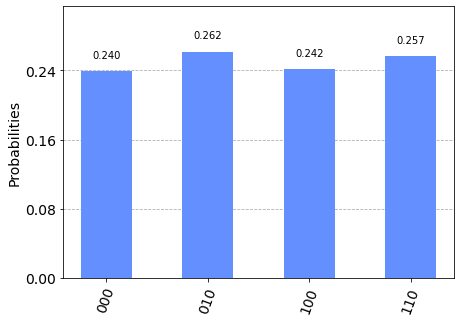

In [5]:
backend = Aer.get_backend('qasm_simulator')
# seeded for reproducibility
results = execute(qc, backend, shots=2048, seed_simulator=42).result()
counts = results.get_counts()
plot_histogram(counts)

In [6]:
rows, eigenvalues = [], []
# getting phase estimates for the outputs
for output in counts:
    decimal = int(output, 2)
    eigenvalue = decimal/(2**n_count)
    eigenvalues.append(eigenvalue)
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), "%i/%i = %.2f" % (decimal, 2**n_count, eigenvalue)])
print(tabulate(rows, headers=["Register Output", "Phase"]))

Register Output    Phase
-----------------  ----------
100(bin) = 4(dec)  4/8 = 0.50
000(bin) = 0(dec)  0/8 = 0.00
010(bin) = 2(dec)  2/8 = 0.25
110(bin) = 6(dec)  6/8 = 0.75


In [7]:
# we use the built-in fraction expansion to find the values of r and test them
print(0.5.as_integer_ratio())
print(0.25.as_integer_ratio())
print(0.75.as_integer_ratio())
# 2 of the values corresponds to an order or period of 4
# we verify that 7^4 = 1(mod 15), so we have found the order

(1, 2)
(1, 4)
(3, 4)


In [8]:
# since 4 is even, then we can compute (a^{r/2} - 1), ((a^{r/2} - 1))
r = 4
res_1 = int(a**(4/2) + 1)
res_2 = int(a**(4/2) - 1)
print(res_1)
print(res_2)

50
48


In [9]:
# we notice that neither are non-trivial factors!
import math
print(math.gcd(res_1, 15))
print(math.gcd(res_2, 15))

5
3
